In [1]:
# import glob
# import pandas as pd

# directoryPath='/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/'

# glued_data = pd.DataFrame()
# for file_name in glob.glob(directoryPath+'*.csv'):
#     x = pd.read_csv(file_name, low_memory=False)
#     glued_data = pd.concat([glued_data,x],axis=0)

In [2]:
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
folder = "KC_AWS/"
date_folder = "2021/09/10/"
files = "*.csv"

path = r"/Users/vivek/Google Drive/Dravam_Vivek/Data/KC_AWS/*.csv"
path = r"/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/*.csv"
path = r"/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/2021/09/05/*.csv"
path = folder+date_folder+files

header_list = [
   "time", "date_year", "date_month", "date_day", 
   "time_hr", "time_min", "time_sec", "time_Msec", 
   "pt_0001_load_value", "tt_0001_load_value", # pressure, temp
   "dp_0001_load_value", "dp_0001_unload_value", # diff pressure low 0-2000, high 0-5000
   "dp_0002_load_value", "dp_0002_unload_value",
   ]

variable_list=[
   "pt_0001_load_value", "tt_0001_load_value", 
   "dp_0001_load_value", "dp_0001_unload_value",
   "dp_0002_load_value", "dp_0002_unload_value"
]

# path='/Users/jufri/Google Drive/Dravam/TS_datavis/KC_AWS/'

# for fname in glob.glob(path):
#    print(fname)
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# print(all_filenames)

all_filenames = [i for i in glob.glob(path)]
all_filenames = sorted(all_filenames)
all_filenames = all_filenames[:]
# for fname in glob.glob(path):
#    print(fname)

# #combine all files in the list
combined_csv = pd.concat([pd.read_csv(f, names=header_list) for f in all_filenames ])
# combined_csv
# #export to csv
# combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [3]:
combined_csv=combined_csv[["time"]+variable_list]



In [4]:
df_events=pd.DataFrame()
df_events_1=pd.DataFrame()
df_events_2=pd.DataFrame()

In [5]:
# # combined_csv2=combined_csv.copy()
# # combined_csv2['time'] = pd.to_datetime(combined_csv['time'], format='%Y-%m-%d %H:%M:%S.%f')
# # combined_csv2.info()

# combined_csv['time'] = pd.to_datetime(combined_csv['time'], format='%Y-%m-%d %H:%M:%S.%f')
# combined_csv.info()


In [6]:
combined_csv=combined_csv.sort_values(by='time', ascending=True)

In [7]:
# 1 sec - 10 datapoints
# 3000 points = 300 secs = 5 min
# 6000 points = 600 secs = 10 min
# 15 mins = 900 secs = 9000 datapoints
# 20 mins = 1200 secs = 12000 datapoints

r_window=9000
event_duration_threshold=12000

combined_csv["dp_0001_load_value_mean"]=combined_csv["dp_0001_load_value"].rolling(r_window, min_periods=1).mean()
combined_csv["dp_0002_load_value_mean"]=combined_csv["dp_0002_load_value"].rolling(r_window, min_periods=1).mean()

combined_csv['dp_0001_load_value_mean_future'] = combined_csv['dp_0001_load_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()
combined_csv['dp_0002_load_value_mean_future'] = combined_csv['dp_0002_load_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()

combined_csv["dp_0001_unload_value_mean"]=combined_csv["dp_0001_unload_value"].rolling(r_window, min_periods=1).mean()
combined_csv["dp_0002_unload_value_mean"]=combined_csv["dp_0002_unload_value"].rolling(r_window, min_periods=1).mean()

combined_csv['dp_0001_unload_value_mean_future'] = combined_csv['dp_0001_unload_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()
combined_csv['dp_0002_unload_value_mean_future'] = combined_csv['dp_0002_unload_value'].shift(-r_window).rolling(r_window, min_periods = 0).mean()


In [8]:
# placeholder for ML algorithm

# combined_csv["event"]=combined_csv.apply(lambda x: 
#     "Loading" 
#     if (x.dp_0001_load_value_mean > 50 or x.dp_0002_load_value_mean > 50 
#         or x.dp_0001_load_value_mean_future > 50 or x.dp_0002_load_value_mean_future > 50)
#     else 
#         ("Unloading" 
#         if (x.dp_0001_unload_value_mean > 50 or x.dp_0002_unload_value_mean > 50 
#             or x.dp_0001_unload_value_mean_future > 50 or x.dp_0002_unload_value_mean_future > 50) 
#         else "")
#     , axis=1
# )

def getEvent(
    dp_0001_load_value_mean, dp_0002_load_value_mean, dp_0001_load_value_mean_future, dp_0002_load_value_mean_future,
    dp_0001_unload_value_mean, dp_0002_unload_value_mean, dp_0001_unload_value_mean_future, dp_0002_unload_value_mean_future,
    pt_0001_load_value):
    
    max_load = max(dp_0001_load_value_mean, dp_0002_load_value_mean, dp_0001_load_value_mean_future, dp_0002_load_value_mean_future)
    max_unload = max(dp_0001_unload_value_mean, dp_0002_unload_value_mean, dp_0001_unload_value_mean_future, dp_0002_unload_value_mean_future)

    if max_load > 50 and max_load > max_unload and pt_0001_load_value < 1:
        return "L"
    elif max_unload > 50 and max_unload > max_load and pt_0001_load_value > 1:
        return "U"
    else:
        return "O"

combined_csv["event"]=combined_csv.apply(lambda x: 
    "Loading" 
    if getEvent(
        x.dp_0001_load_value_mean, x.dp_0002_load_value_mean, x.dp_0001_load_value_mean_future, x.dp_0002_load_value_mean_future,
        x.dp_0001_unload_value_mean, x.dp_0002_unload_value_mean, x.dp_0001_unload_value_mean_future, x.dp_0002_unload_value_mean_future,
        x.pt_0001_load_value)=="L"
    else ("Unloading" if (getEvent(
        x.dp_0001_load_value_mean, x.dp_0002_load_value_mean, x.dp_0001_load_value_mean_future, x.dp_0002_load_value_mean_future,
        x.dp_0001_unload_value_mean, x.dp_0002_unload_value_mean, x.dp_0001_unload_value_mean_future, x.dp_0002_unload_value_mean_future,
        x.pt_0001_load_value))=="U" else "" )
    , axis=1
)

In [9]:
# check for "Loading" events
combined_csv[combined_csv["event"]=='Loading']
combined_csv[combined_csv["event"]=='Unloading']
# combined_csv[combined_csv.dp_0001_load_value>50].head(100)


time  pt_0001_load_value  tt_0001_load_value  \
4544  2021-09-10 06:55:51.685039             1.00375           26.856251   
4545  2021-09-10 06:55:51.778788             1.00875           26.850000   
4546  2021-09-10 06:55:51.872536             1.01750           26.856251   
4547  2021-09-10 06:55:51.981913             1.03000           26.850000   
4548  2021-09-10 06:55:52.075661             1.04000           26.850000   
...                          ...                 ...                 ...   
2387  2021-09-10 23:22:15.979699             1.05750           41.668751   
2388  2021-09-10 23:22:16.073449             1.04250           41.668751   
2389  2021-09-10 23:22:16.182823             1.03375           41.668751   
2390  2021-09-10 23:22:16.276573             1.02000           41.662498   
2391  2021-09-10 23:22:16.370325             1.01250           41.662498   

      dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
4544               0.000                 0.000             83.1250   
4545               0.000                 0.000             85.3125   
4546               0.000                 0.000             87.5000   
4547               0.000                 0.000             91.2500   
4548               0.000                 0.000             93.4375   
...                  ...                   ...                 ...   
2387             194.625               277.875              0.0000   
2388             180.750               291.125              0.0000   
2389             176.500               296.750              0.0000   
2390             167.875               309.875              0.0000   
2391             163.750               309.875              0.0000   

      dp_0002_unload_value  dp_0001_load_value_mean  dp_0002_load_value_mean  \
4544                0.0000                21.331833                10.090451   
4545                0.0000                21.330319                10.099306   
4546                0.0000                21.328639                10.108194   
4547                0.0000                21.326903                10.117396   
4548                0.0000                21.325097                10.126597   
...                    ...                      ...                      ...   
2387              236.8750                88.811431                38.278854   
2388              242.8125                88.831514                38.269306   
2389              250.0000                88.851125                38.260764   
2390              263.1250                88.869778                38.255347   
2391              265.3125                88.887972                38.251632   

      dp_0001_load_value_mean_future  dp_0002_load_value_mean_future  \
4544                        9.621542                       21.843681   
4545                        9.621542                       21.834201   
4546                        9.621542                       21.824479   
4547                        9.621542                       21.814340   
4548                        9.621542                       21.803958   
...                              ...                             ...   
2387                        9.248847                        3.711181   
2388                        9.228764                        3.712882   
2389                        9.209153                        3.714340   
2390                        9.190500                        3.715625   
2391                        9.172306                        3.716389   

      dp_0001_unload_value_mean  dp_0002_unload_value_mean  \
4544                  44.766597                  50.920417   
4545                  44.764444                  50.915833   
4546                  44.762778                  50.911424   
4547                  44.761264                  50.907083   
4548                  44.760083                  50.902847   
...                         ...                        ...   
2387          

In [10]:
# # combined_csv[combined_csv["time"]=='2021-09-05 05:00:00.074017']
# combined_csv[combined_csv["event_grp"].isin(['1','2','3'])]
# combined_csv.to_csv("checkhere.csv")
# # combined_csv[combined_csv['time'].str.contains("2021-09-05 05:00")]


In [11]:
# group consecutive events
combined_csv["event_grp"]=(combined_csv.event != combined_csv.event.shift()).cumsum()
combined_csv.head()

time  pt_0001_load_value  tt_0001_load_value  \
0  2021-09-10 00:08:17.283188                 0.0           42.481251   
1  2021-09-10 00:08:17.376938                 0.0           42.481251   
2  2021-09-10 00:08:17.470688                 0.0           42.481251   
3  2021-09-10 00:08:17.580065                 0.0           42.481251   
4  2021-09-10 00:08:17.673813                 0.0           42.481251   

   dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
0             602.500                   0.0             207.500   
1             583.750                   0.0             214.375   
2             572.250                   0.0             215.625   
3             569.625                   0.0             215.000   
4             590.625                   0.0             201.250   

   dp_0002_unload_value  dp_0001_load_value_mean  dp_0002_load_value_mean  \
0                   0.0               602.500000                 207.5000   
1                   0.0               593.125000                 210.9375   
2                   0.0               586.166667                 212.5000   
3                   0.0               582.031250                 213.1250   
4                   0.0               583.750000                 210.7500   

   dp_0001_load_value_mean_future  dp_0002_load_value_mean_future  \
0                      565.500000                      197.500000   
1                      562.375000                      201.093750   
2                      558.791667                      213.020833   
3                      555.812500                      230.703125   
4                      552.875000                      248.750000   

   dp_0001_unload_value_mean  dp_0002_unload_value_mean  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   dp_0001_unload_value_mean_future  dp_0002_unload_value_mean_future  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

     event  event_grp  
0  Loading          1  
1  Loading          1  
2  Loading          1  
3  Loading          1  
4  Loading          1

In [12]:
combined_csv.groupby(['event_grp']).agg(lambda x:x.value_counts().index[0])


time  pt_0001_load_value  tt_0001_load_value  \
event_grp                                                                       
1          2021-09-10 00:16:58.579969             0.00000           42.218750   
2          2021-09-10 06:52:46.575695             0.00000           32.281250   
3          2021-09-10 07:00:22.981864             4.95375           42.137501   
4          2021-09-10 10:05:25.082057             0.54500           41.243752   
5          2021-09-10 10:08:05.972650             1.38250           41.037498   
6          2021-09-10 10:08:12.082026             0.99500           41.075001   
7          2021-09-10 10:16:11.972563             1.39875           40.487499   
8          2021-09-10 10:20:37.972519             1.39500           40.462502   
9          2021-09-10 10:25:48.378710             1.37875           40.299999   
10         2021-09-10 13:24:17.783033             0.10250           35.787498   
11         2021-09-10 16:46:34.077722             4.63375           42.156250   
12         2021-09-10 17:26:41.374165             0.10750           41.037498   
13         2021-09-10 17:28:52.874141             0.10625           41.337502   
14         2021-09-10 18:33:11.779695             0.01875           41.424999   
15         2021-09-10 21:24:29.684097             4.94250           41.799999   
16         2021-09-10 23:25:48.370285             0.00000           39.868752   
17         2021-09-10 23:28:00.682764             0.00000           39.581249   
18         2021-09-10 23:35:55.370164             0.00000           37.593750   

           dp_0001_load_value  dp_0001_unload_value  dp_0002_load_value  \
event_grp                                                                 
1                         0.0                   0.0              0.0000   
2                         0.0                   0.0              0.0000   
3                         0.0                   0.0              0.0000   
4                         0.0                   0.0              0.0000   
5                         0.0                   0.0              0.0000   
6                       104.5                   0.0             34.0625   
7                         0.0                   0.0              0.0000   
8                         0.0                   0.0              0.0000   
9                         0.0                   0.0              0.0000   
10                        0.0                   0.0              0.0000   
11                        0.0                   0.0              0.0000   
12                        0.0                   0.0              0.0000   
13                        0.0                   0.0              0.0000   
14                        0.0                   0.0              0.0000   
15                        0.0                   0.0              0.0000   
16                        0.0                   0.0              0.0000   
17                        0.0                   0.0              0.0000   
18                        0.0                   0.0              0.0000   

           dp_0002_unload_value  dp_0001_load_value_mean  \
event_grp                                                  
1                           0.0               626.999347   
2                           0.0                 0.000000   
3                           0.0                 0.000000   
4                           0.0                12.171458   
5                           0.0                44.775556   
6                           0.0                47.078833   
7                           0.0                47.613319   
8                           0.0                70.293833   
9                           0.0                30.451014   
10                          0.0                 1.180681   
11                          0.0                 0.000000   
12                          0.0                61.750444   
13                          0.0                63.370014   
14         

In [13]:
# find obvious groups / events
df_loading=combined_csv[combined_csv["event"]=="Loading"].groupby("event_grp").agg({'time': [("Start Time",np.min),("End Time",np.max),("Count",np.count_nonzero)]})
df_unloading=combined_csv[combined_csv["event"]=="Unloading"].groupby("event_grp").agg({'time': [("Start Time",np.min),("End Time",np.max),("Count",np.count_nonzero)]})
# df_loading["time"]["event"]="Loading"
print(df_loading)
print(df_unloading)

                                 time                                   
                           Start Time                    End Time  Count
event_grp                                                               
1          2021-09-10 00:08:17.283188  2021-09-10 00:49:16.673371  24595
13         2021-09-10 17:27:26.171031  2021-09-10 17:28:54.983515    889
17         2021-09-10 23:25:52.870284  2021-09-10 23:28:43.682755   1709
                                 time                                    
                           Start Time                    End Time   Count
event_grp                                                                
3          2021-09-10 06:55:51.685039  2021-09-10 10:05:08.175807  113567
5          2021-09-10 10:06:02.878923  2021-09-10 10:08:11.785149    1290
7          2021-09-10 10:08:12.472650  2021-09-10 10:19:10.581906    6582
9          2021-09-10 10:21:28.581882  2021-09-10 10:25:54.675583    2662
11         2021-09-10 15:23:21.578621  2021-

In [14]:

df_events_1["Start Time"]=df_loading["time"]["Start Time"]
df_events_1["End Time"]=df_loading["time"]["End Time"]
df_events_1["Count"]=df_loading["time"]["Count"]
df_events_1["Event"]=df_events_1["Count"].apply(lambda x: "Loading" if x >= event_duration_threshold else "Outlier")
df_events_1

Start Time                    End Time  Count    Event
1   2021-09-10 00:08:17.283188  2021-09-10 00:49:16.673371  24595  Loading
13  2021-09-10 17:27:26.171031  2021-09-10 17:28:54.983515    889  Outlier
17  2021-09-10 23:25:52.870284  2021-09-10 23:28:43.682755   1709  Outlier

In [15]:

df_events_2["Start Time"]=df_unloading["time"]["Start Time"]
df_events_2["End Time"]=df_unloading["time"]["End Time"]
df_events_2["Count"]=df_unloading["time"]["Count"]
df_events_2["Event"]=df_events_2["Count"].apply(lambda x: "Unloading" if x >= event_duration_threshold else "Outlier")
df_events_2

Start Time                    End Time   Count      Event
3   2021-09-10 06:55:51.685039  2021-09-10 10:05:08.175807  113567  Unloading
5   2021-09-10 10:06:02.878923  2021-09-10 10:08:11.785149    1290    Outlier
7   2021-09-10 10:08:12.472650  2021-09-10 10:19:10.581906    6582    Outlier
9   2021-09-10 10:21:28.581882  2021-09-10 10:25:54.675583    2662    Outlier
11  2021-09-10 15:23:21.578621  2021-09-10 17:21:35.077344   70936  Unloading
15  2021-09-10 20:25:26.278483  2021-09-10 23:22:16.370325  106102  Unloading

In [16]:
# 1 sec - 10 datapoints
# 3000 points = 300 secs = 5 min
# 15 mins = 900 secs = 9000 datapoints
# 20 mins = 1200 secs = 12000 datapoints

df_events = pd.concat([df_events_1, df_events_2])
df_events=df_events.sort_values(by='Start Time', ascending=True)
df_events["event_seconds"]=df_events["Count"]/10
df_events["event_minutes"]=df_events["Count"]/10/60
df_events["event_hour"]=df_events["Count"]/10/60/60
df_events

Start Time                    End Time   Count      Event  \
1   2021-09-10 00:08:17.283188  2021-09-10 00:49:16.673371   24595    Loading   
3   2021-09-10 06:55:51.685039  2021-09-10 10:05:08.175807  113567  Unloading   
5   2021-09-10 10:06:02.878923  2021-09-10 10:08:11.785149    1290    Outlier   
7   2021-09-10 10:08:12.472650  2021-09-10 10:19:10.581906    6582    Outlier   
9   2021-09-10 10:21:28.581882  2021-09-10 10:25:54.675583    2662    Outlier   
11  2021-09-10 15:23:21.578621  2021-09-10 17:21:35.077344   70936  Unloading   
13  2021-09-10 17:27:26.171031  2021-09-10 17:28:54.983515     889    Outlier   
15  2021-09-10 20:25:26.278483  2021-09-10 23:22:16.370325  106102  Unloading   
17  2021-09-10 23:25:52.870284  2021-09-10 23:28:43.682755    1709    Outlier   

    event_seconds  event_minutes  event_hour  
1          2459.5      40.991667    0.683194  
3         11356.7     189.278333    3.154639  
5           129.0       2.150000    0.035833  
7           658.2      10.970000    0.182833  
9           266.2       4.436667    0.073944  
11         7093.6     118.226667    1.970444  
13           88.9       1.481667    0.024694  
15        10610.2     176.836667    2.947278  
17          170.9       2.848333    0.047472

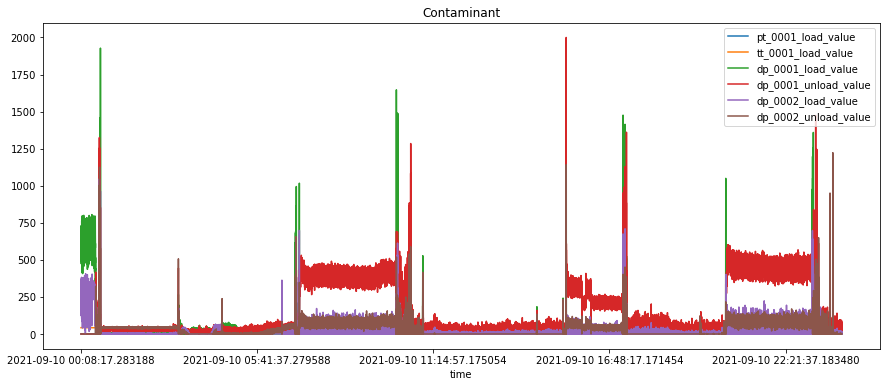

In [17]:
combined_csv[["time"]+variable_list].plot(x='time', title='Contaminant', figsize=(15, 6));

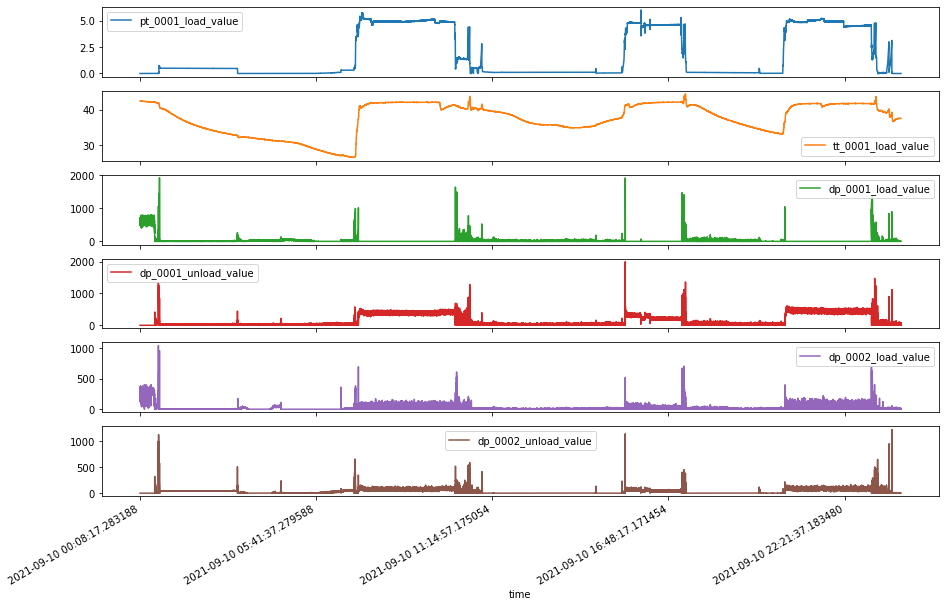

In [18]:
# Plot each feature on own axis for clearer view of any pattern
combined_csv[["time"]+variable_list].plot(x='time',subplots=True, sharex=True, figsize=(15,10))
plt.show()

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

shapes_list=[]

for x in range(df_events.shape[0]):
        
    if df_events["Event"].iloc[x]=="Loading":
        fillcolor="rgba(63, 81, 181, 0.2)" # blue
    elif df_events["Event"].iloc[x]=="Unloading":
        fillcolor="rgba(76, 175, 80, 0.1)" # green
    elif df_events["Event"].iloc[x]=="Outlier":
        fillcolor="rgba(181, 76, 80, 0.1)" # red
    else:
        fillcolor="rgba(255, 255, 255, 0.1)", # black

    shapes_list.append(dict(
            fillcolor=fillcolor,
            line={"width": 0},
            type="rect",
            # x0=df_loading["time"]["Start Time"].iloc[x],
            # x1=df_loading["time"]["End Time"].iloc[x],
            x0=df_events["Start Time"].iloc[x],
            x1=df_events["End Time"].iloc[x],
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        ))

# for x in range(df_events[df_events["Event"]=="Unloading"].shape[0]):
#     shapes_list.append(dict(
#             fillcolor="rgba(76, 175, 80, 0.1)",
#             line={"width": 0},
#             type="rect",
#             # x0=df_loading["time"]["Start Time"].iloc[x],
#             # x1=df_loading["time"]["End Time"].iloc[x],
#             x0=df_events["Start Time"].iloc[x],
#             x1=df_events["End Time"].iloc[x],
#             xref="x",
#             y0=0,
#             y1=0.95,
#             yref="paper"
#         ))

# for x in range(df_events[df_events["Event"]=="Outlier"].shape[0]):
#     shapes_list.append(dict(
#             fillcolor="rgba(181, 76, 80, 0.1)",
#             line={"width": 0},
#             type="rect",
#             # x0=df_loading["time"]["Start Time"].iloc[x],
#             # x1=df_loading["time"]["End Time"].iloc[x],
#             x0=df_events["Start Time"].iloc[x],
#             x1=df_events["End Time"].iloc[x],
#             xref="x",
#             y0=0,
#             y1=0.95,
#             yref="paper"
#         ))
shapes_list

[{'fillcolor': 'rgba(63, 81, 181, 0.2)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': '2021-09-10 00:08:17.283188',
  'x1': '2021-09-10 00:49:16.673371',
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(76, 175, 80, 0.1)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': '2021-09-10 06:55:51.685039',
  'x1': '2021-09-10 10:05:08.175807',
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(181, 76, 80, 0.1)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': '2021-09-10 10:06:02.878923',
  'x1': '2021-09-10 10:08:11.785149',
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(181, 76, 80, 0.1)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': '2021-09-10 10:08:12.472650',
  'x1': '2021-09-10 10:19:10.581906',
  'xref': 'x',
  'y0': 0,
  'y1': 0.95,
  'yref': 'paper'},
 {'fillcolor': 'rgba(181, 76, 80, 0.1)',
  'line': {'width': 0},
  'type': 'rect',
  'x0': '2021-09-10 10:21:28.581882',
  '

In [20]:
# # combined_csv
# # variable_list=[
# #    "pt_0001_load_value", "tt_0001_load_value", 
# #    "dp_0001_load_value", "dp_0001_unload_value",
# #    "dp_0002_load_value", "dp_0002_unload_value"
# # ]

fig = make_subplots(rows=6, cols=1, vertical_spacing=0.065, shared_xaxes=True)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.pt_0001_load_value), name="pt_0001_load_value"), 1, 1)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.tt_0001_load_value), name="tt_0001_load_value"), 2, 1)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.dp_0001_load_value), name="dp_0001_load_value"), 3, 1)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.dp_0001_unload_value), name="dp_0001_unload_value"), 4, 1)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.dp_0002_load_value), name="dp_0002_load_value"), 5, 1)
fig.add_trace(
    go.Scatter(x=list(combined_csv.time), y=list(combined_csv.dp_0002_unload_value), name="dp_0002_unload_value"), 6, 1);



# Add shapes
fig.update_layout(
    shapes=shapes_list
    # [
    #     dict(
    #         fillcolor="rgba(63, 81, 181, 0.2)",
    #         line={"width": 0},
    #         type="rect",
    #         x0=df_loading["time"]["amin"].iloc[0],
    #         x1=df_loading["time"]["amax"].iloc[0],
    #         xref="x",
    #         y0=0,
    #         y1=0.95,
    #         yref="paper"
    #     ),
    #     dict(
    #         fillcolor="rgba(76, 175, 80, 0.1)",
    #         line={"width": 0},
    #         type="rect",
    #         x0=df_loading["time"]["amin"].iloc[1],
    #         x1=df_loading["time"]["amax"].iloc[1],
    #         xref="x",
    #         y0=0,
    #         y1=0.95,
    #         yref="paper"
    #     ),
    #     dict(
    #         fillcolor="rgba(63, 81, 181, 0.2)",
    #         line={"width": 0},
    #         type="rect",
    #         x0=df_loading["time"]["amin"].iloc[2],
    #         x1=df_loading["time"]["amax"].iloc[2],
    #         xref="x",
    #         y0=0,
    #         y1=0.95,
    #         yref="paper"
    #     ),
    #     dict(
    #         fillcolor="rgba(63, 81, 181, 0.2)",
    #         line={"width": 0},
    #         type="rect",
    #         x0=df_loading["time"]["amin"].iloc[3],
    #         x1=df_loading["time"]["amax"].iloc[3],
    #         xref="x",
    #         y0=0,
    #         y1=0.95,
    #         yref="paper"
    #     ),
    # ]
)

fig.update_layout(
    height=800,
    title_text="Time series with range slider and selectors")


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=[
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
        type="date"),#end xaxis  definition
    
    xaxis6_rangeslider_visible=True,
    xaxis6_type="date"
    );
# fig.show()

fig.write_html(date_folder.replace("/","")+".html")
# fig.write_image(date_folder+date_folder+"fig1.png")



In [21]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create figure
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x=list(combined_csv.time), y=list(combined_csv.dp_0001_unload_value)))

# # Set title
# fig.update_layout(
#     title_text="Time series with range slider and selectors"
# )

# # Add range slider
# fig.update_layout(
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label="1m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=6,
#                      label="6m",
#                      step="month",
#                      stepmode="backward"),
#                 dict(count=1,
#                      label="YTD",
#                      step="year",
#                      stepmode="todate"),
#                 dict(count=1,
#                      label="1y",
#                      step="year",
#                      stepmode="backward"),
#                 dict(step="all")
#             ])
#         ),
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# fig.show()